In [1]:
import torch
import torch
from torch.utils.data import DataLoader
import pandas as pd
import glob

import segmentation_models_pytorch as smp

import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import WandbLogger

from lightning_module import LitUNetPlusPlus
from config import Config
from dataset import *
import wandb
import seaborn as sns

import monai
from monai.transforms import *

from tabulate import tabulate
import matplotlib.pyplot as plt

seed_everything(99, workers=True)

from lightning.pytorch.plugins.environments import SLURMEnvironment
SLURMEnvironment.detect = lambda: False

cfg = Config(experiment_name = "Nothing")



Seed set to 99


In [2]:
single_domains = [
    "Spectralis",
    "Topcon",
    "Cirrus"
]

mean_normal = [
    "Spectralis-Cirrus-val",
    "Topcon-Cirrus-val",
    "Spectralis-Topcon-val"
]
mean_nosvdna = [
    "Spectralis-Cirrus-noSVDNA-val",
    "Spectralis-Topcon-noSVDNA-val",
    "Topcon-Cirrus-noSVDNA-val"
]

ablation = [
    "Spectralis-Cirrus-HistmatchingOnly",
    "Spectralis-Cirrus-NoiseAdaptOnly",
    "Spectralis-Cirrus",
    "Supervised"
]

all_models = list(reversed([
    "Supervised",
    "Spectralis-Cirrus",
    "Topcon-Cirrus",
    "Spectralis-Topcon",
    "Spectralis-Cirrus-noSVDNA",
    "Spectralis-Topcon-noSVDNA",
    "Topcon-Cirrus-noSVDNA",
    "Spectralis",
    "Topcon",
    "Cirrus",
    "Untrained"
]))

In [30]:

# Get the path to the "results" folder
results_folder = os.path.join(os.getcwd(), "results")

# Get all files in the "results" folder that match the pattern "results_mean_*.csv"
file_list = glob.glob(os.path.join(results_folder, "*/results_*.csv"), recursive=True)
#file_list = [f for f in file_list if "-val" in f]
# Load each file into a pandas DataFrame and concatenate them
dfs = []
for file in file_list:
    file_path = os.path.join(results_folder, file)
    df = pd.read_csv(file_path, index_col=0)
    dfs.append(df)

result = pd.concat(dfs)

result = result[result["Task"] != "Background"]

# change all rows with task "SRD" to "SRF"
result.loc[result["Task"] == "SRD", "Task"] = "SRF"

/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/moritz/miniconda3/envs/optima/lib/p

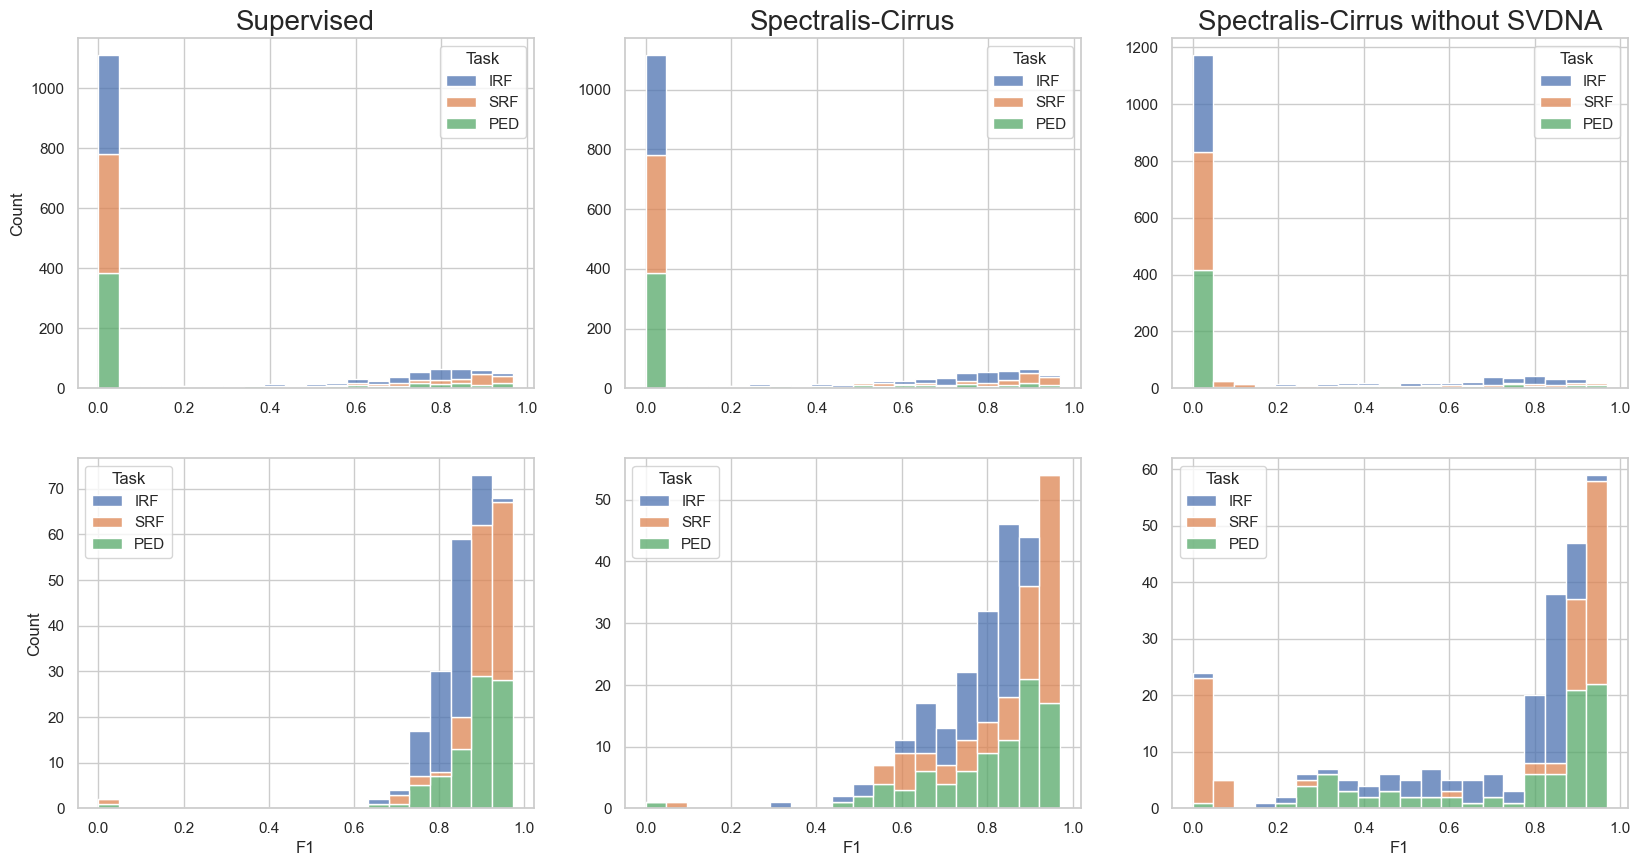

In [37]:
# plot a histogram of F1 in result

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(2 , 3, figsize=(20, 10))

sns.histplot(result[result["Model"] == "Supervised"], x="F1", hue="Task", multiple="stack", bins=20, ax=ax[0, 0])
ax[0,0].set_title("Supervised")
sns.histplot(result[result["Model"] == "Spectralis-Cirrus"], x="F1", hue="Task", multiple="stack", bins=20, ax=ax[0, 1])
ax[0,1].set_title("Spectralis-Cirrus")
sns.histplot(result[result["Model"] == "Spectralis-Cirrus-noSVDNA"], x="F1", hue="Task", multiple="stack", bins=20, ax=ax[0, 2])
ax[0,2].set_title("Spectralis-Cirrus without SVDNA")
sns.histplot(result[result["Model"] == "Supervised-val"], x="F1", hue="Task", multiple="stack", bins=20, ax=ax[1, 0])
ax[1,0].set_title(" ")
sns.histplot(result[result["Model"] == "Spectralis-Cirrus-val"], x="F1", hue="Task", multiple="stack", bins=20, ax=ax[1, 1])
ax[1,1].set_title(" ")
sns.histplot(result[result["Model"] == "Spectralis-Cirrus-noSVDNA-val"], x="F1", hue="Task", multiple="stack", bins=20, ax=ax[1, 2])
ax[1,2].set_title(" ")

# remove y axis labels and reduce  title size
for i in range(2):
    for j in range(3):
        ax[i, j].set_ylabel("")
        ax[i, 0].set_ylabel("Count")
        ax[1, j].set_xlabel("F1")
        ax[0, j].set_xlabel("")
        ax[i, j].set_title(ax[i, j].get_title(), fontsize=20)

plt.show()

### Supervised

In [20]:
supervised = result[result["Model"] == "Supervised-val"]
x = supervised.groupby(["Task", "Model"]).mean().reset_index()
y = supervised.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x

,Model,F1
0,Supervised-val,0.867 (0.09)


#### Untrained

In [21]:
untrained = result[result["Model"] == "Untrained-val"]
x = untrained.groupby(["Task", "Model"]).mean().reset_index()
y = untrained.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
#x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
#y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x

,Task,Model,F1
0,IRF,Untrained-val,0.01 (0.01)
1,PED,Untrained-val,0.017 (0.02)
2,SRF,Untrained-val,0.0 (0.0)


In [22]:
svdna = result[result["Model"].isin(mean_normal)]
x = svdna.groupby(["Task", "Model"]).mean().reset_index()
y = svdna.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
#x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
#y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x

,Task,Model,F1
0,IRF,Spectralis-Cirrus-val,0.778 (0.11)
1,IRF,Spectralis-Topcon-val,0.743 (0.14)
2,IRF,Topcon-Cirrus-val,0.766 (0.13)
3,PED,Spectralis-Cirrus-val,0.803 (0.16)
4,PED,Spectralis-Topcon-val,0.767 (0.17)
5,PED,Topcon-Cirrus-val,0.816 (0.16)
6,SRF,Spectralis-Cirrus-val,0.842 (0.14)
7,SRF,Spectralis-Topcon-val,0.821 (0.16)
8,SRF,Topcon-Cirrus-val,0.865 (0.11)


In [24]:
no_svdna = result[result["Model"].isin(mean_nosvdna)]
x = no_svdna.groupby(["Task", "Model"]).mean().reset_index()
y = no_svdna.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x


,Model,F1
0,Spectralis-Cirrus-noSVDNA-val,0.694 (0.29)
1,Spectralis-Topcon-noSVDNA-val,0.713 (0.21)
2,Topcon-Cirrus-noSVDNA-val,0.8 (0.17)


In [9]:
single = result[result["Model"].isin(single_domains)]
x = single.groupby(["Task", "Model"]).mean().reset_index()
y = single.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
#x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x

,Task,Model,F1


In [10]:
single = result[result["Model"].isin(ablation)]
x = single.groupby(["Task", "Model"]).mean().reset_index()
y = single.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x

,Model,F1
